# Mixing in a homogeneous magnetic field

This tutorial demonstrates the most simple use case of the gammaALPs code, namely the mixing between photons and ALPs in a homogeneous magnetic field. The magnetic-field parameters are probably not very realisitic, but the results nicely illustrate some of the main features of photon-ALP mixing. 

We first import the relevant modules:

In [1]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base.transfer import EminGeV, EmaxGeV
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from astropy import units as u

And set the ALP parameters:

In [2]:
m, g = 10., 3.
alp = ALP(m, g)

Let's define an energy range for this example, in GeV.

In [3]:
EGeV = np.logspace(0.,8.,1000)

For the initial polarization, we use a fully polarized photon beam,

In [4]:
pin = np.diag((1., 0., 0.))

And we define some dummy source:

In [5]:
src = Source(z=0., l=0., b=0.)

With the defined `alp`, `src`, initial polarization `pin` and energy range `EGeV`, we can now initialize our module list

In [6]:
ml = ModuleList(alp, src, pin=pin, EGeV=EGeV, seed=0)

We add a single propagation enivironment, mixing in a cell-like field in a galaxy cluster. 
By setting `eta` and `beta` to zero, we force the electron density to be constant, so 
that neither the magnetic field nor the electron density change with propagation distance. 
We choose arbitrary values for B-field strength and electron density that give nice results for illustration. 

In [7]:
ml.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=1.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=10.1,  # full path, chosen that we only have a single cell
                   beta=0., 
                   eta=0.
                  )

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0


Now we explicitly set the angle $\psi$ between the transversal magnetic field and the $x$ direction to $\pi / 2$ so that the $x$ polarization will fully mix. 

In [8]:
ml.modules[0].psin = np.ones_like(ml.modules[0].psin) * np.pi / 2.

We run the photon-ALP calculation to get the final oscillation probabilities into the two photon polarization states and into the ALP state

In [9]:
px, py, pa = ml.run()
print (pa.shape)

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>


(1, 1000)


And plot the results:

Text(0, 0.5, '$P_{a\\gamma}$')

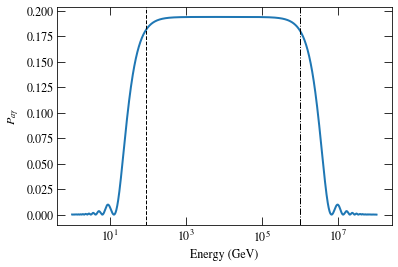

In [10]:
plt.semilogx(EGeV, pa[0], lw=2)

# the critical energy, onset of strong mixing regime
plt.axvline(EminGeV(m_neV=ml.alp.m, g11=ml.alp.g, BmuG=ml.modules[0].B, n_cm3=ml.modules[0].nel),
            lw=1., ls='--', color='k')

# maximum energy, end of strong mixing regime
plt.axvline(EmaxGeV(g11=ml.alp.g, BmuG=ml.modules[0].B),
            lw=1., ls='-.', color='k')

plt.xlabel("Energy (GeV)")
plt.ylabel("$P_{a\gamma}$")

# Do the same but for ALPs experiment

In [11]:
# center energy around 1064 nm
wavelength = 1064 * u.nm
energy = ((c.c / wavelength.to('m')) * c.h).to('eV')
print(energy)

1.1652650228684234 eV


In [12]:
EGeV = np.logspace(np.log10(energy.value) - 4,np.log10(energy.value) + 14.5, 2000) * u.eV.to("GeV")

ALPS II specs

In [13]:
B = 5.3 * u.T.to('1e-6G')
L = 8.8 * 12 * u.m.to('kpc')
print(B, L)

53000000000.0 3.42226292965325e-18


In [14]:
pin = np.diag((1., 0., 0.))

In [15]:
ml_alps = ModuleList(alp, src, pin=pin, EGeV=EGeV, seed=0)

In [16]:
ml_alps.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=B,  # B field strength
                   L0=L,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-100,  # electron density
                   r_abell=L * 1.1,  # full path, chosen that we only have a single cell
                   beta=0., 
                   eta=0.
                  )

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0


In [17]:
ml_alps.modules[0].psin = np.ones_like(ml_alps.modules[0].psin) * np.pi / 2.

In [18]:
ml_alps.alp.m = 1e4
ml_alps.alp.g = 2.

In [19]:
px, py, pa = ml_alps.run()
print (pa.shape)

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>


(1, 2000)


In [20]:
Dosc = np.real(np.squeeze(ml_alps.modules[0]._Dosc))
Dag = np.real(np.squeeze(ml_alps.modules[0]._Dag))
Da = np.real(np.squeeze(ml_alps.modules[0]._Da))
Pag_analytical = Dag ** 2. * (np.sin(Dosc * L / 2.))**2. / (Dosc / 2.)**2.
EeV = EGeV * u.GeV.to('eV')

Text(0, 0.5, '$P_{a\\gamma}$')

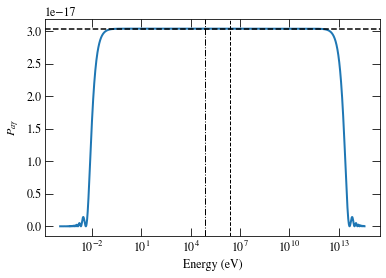

In [21]:
plt.semilogx(EGeV * u.GeV.to('eV'), (pa)[0], lw=2)

# the critical energy, onset of strong mixing regime
plt.axvline(EminGeV(m_neV=ml_alps.alp.m,
                    g11=ml_alps.alp.g,
                    BmuG=ml_alps.modules[0].B,
                    n_cm3=ml_alps.modules[0].nel) * u.GeV.to('eV'),
            lw=1., ls='--', color='k')

# maximum energy, end of strong mixing regime
plt.axvline(EmaxGeV(g11=ml_alps.alp.g, BmuG=ml_alps.modules[0].B) * u.GeV.to('eV'),
            lw=1., ls='-.', color='k')


Pag_approx = (Dag[int(len(Dag) / 2)] * L)**2.
plt.axhline(Pag_approx, ls='--', color='k')

plt.xlabel("Energy (eV)")
plt.ylabel("$P_{a\gamma}$")

Text(0, 0.5, '$P_{a\\gamma}$')

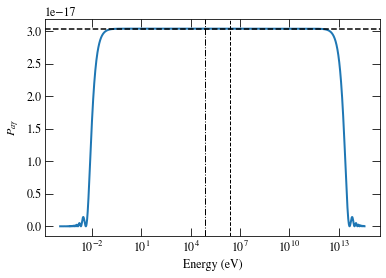

In [22]:
plt.semilogx(EGeV * u.GeV.to('eV'), (pa)[0], lw=2)

# the critical energy, onset of strong mixing regime
plt.axvline(EminGeV(m_neV=ml_alps.alp.m,
                    g11=ml_alps.alp.g,
                    BmuG=ml_alps.modules[0].B,
                    n_cm3=ml_alps.modules[0].nel) * u.GeV.to('eV'),
            lw=1., ls='--', color='k')

# maximum energy, end of strong mixing regime
plt.axvline(EmaxGeV(g11=ml_alps.alp.g, BmuG=ml_alps.modules[0].B) * u.GeV.to('eV'),
            lw=1., ls='-.', color='k')


Pag_approx = (Dag[int(len(Dag) / 2)] * L)**2.
plt.axhline(Pag_approx, ls='--', color='k')

plt.xlabel("Energy (eV)")
plt.ylabel("$P_{a\gamma}$")

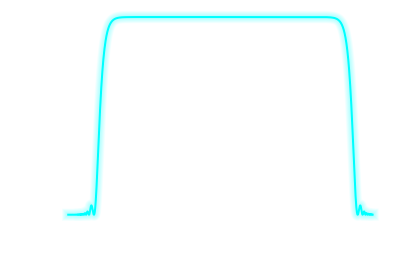

In [23]:
from matplotlib.ticker import NullFormatter, LogLocator

plt.semilogx(EGeV * u.GeV.to('eV'), (pa)[0] * 1e17, lw=2, color='cyan')

# the critical energy, onset of strong mixing regime
#plt.axvline(EminGeV(m_neV=ml_alps.alp.m,
#                    g11=ml_alps.alp.g,
#                    BmuG=ml_alps.modules[0].B,
#                    n_cm3=ml_alps.modules[0].nel) * u.GeV.to('eV'),
#            lw=1., ls='--', color='k')

# maximum energy, end of strong mixing regime
#plt.axvline(EmaxGeV(g11=ml_alps.alp.g, BmuG=ml_alps.modules[0].B) * u.GeV.to('eV'),
#            lw=1., ls='-.', color='k')
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.03

for n in range(1, n_lines+1):    
    plt.semilogx(
        EGeV * u.GeV.to('eV'), (pa)[0] * 1e17,
        linewidth=2+(diff_linewidth*n),
        alpha=alpha_value,
        color='cyan')

Pag_approx = (Dag[int(len(Dag) / 2)] * L)**2.
#plt.axhline(Pag_approx, ls='--', color='k')

plt.xlabel("Energy (eV)", fontsize='x-large', color='white')
plt.ylabel("$P_{a\gamma} (10^{-17})$", fontsize='x-large', color='white')
ax = plt.gca()
ax.tick_params(labelsize='x-large', color='white', labelcolor='white', which='both')
x_major = LogLocator(base = 10.0, numticks = 10)
ax.xaxis.set_major_locator(x_major)
x_minor = LogLocator(base = 10.0, numticks = 30)
ax.xaxis.set_minor_locator(x_minor)
ax.xaxis.set_minor_formatter(NullFormatter())

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
#ax.grid(color='0.9', lw=0.5, ls='-')
plt.savefig("ALPS_II_conversion_prob.png", transparent=True, dpi=200)

[1. 1. 1. ... 1. 1. 1.]


0.3183098861837907

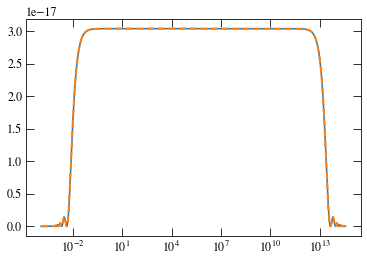

In [24]:
plt.semilogx(EeV, Pag_analytical)
plt.semilogx(EeV, (pa)[0], lw=2, ls='--')
print(Pag_analytical / (pa)[0])
Pag_analytical[-1] / (pa)[0,-1] / np.pi

In [25]:
laser_power = 150e3 * u.J / u.s  # laser power times power build up in production cavity
build_up_rc = 17e3
overlap = 0.95

photon_rate = overlap ** 2. * laser_power * build_up_rc / energy.to('J') * Pag_approx ** 2.

In [26]:
print(photon_rate)

1.1394718255959822e-05 1 / s


In [27]:
Tobs = 1. * u.day.to('s') * u.s

In [28]:
photon_rate * Tobs

<Quantity 0.98450366>

In [29]:
1e5 * u.J / u.s / energy.to('J')

<Quantity 5.35630003e+23 1 / s>

In [30]:
laser_power / 35

<Quantity 4285.71428571 J / s>

## Solar axions from Primakoff

In [31]:
def primakoff_solar(EkeV, g):
    """In axions / s / keV / cm^2, E in keV, g in 1e-11 GeV^-1"""
    norm = 6.02e10
    result = norm * (g / 10.)**2.
    result *= EkeV ** 2.2481
    result /= np.exp(EkeV / 1.205)
    return result

In [32]:
EkeV = np.logspace(-5, 2, 200)

In [33]:
f = primakoff_solar(EkeV, 2.)

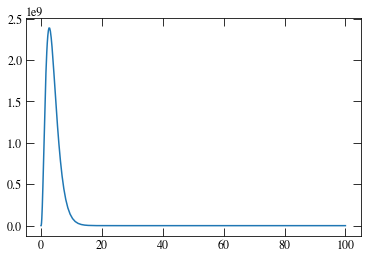

In [34]:
plt.plot(EkeV, f)

In [35]:
from scipy.integrate import simps

In [36]:
f_integral = simps(f * EkeV, np.log(EkeV))
print("{0:e}".format(f_integral))

1.122756e+10


### IAXO parameters

In [37]:
B = 2.5 * u.T.to("1e-6 G")
L = 20 * u.m.to("kpc")
A = 8. * (0.6 * u.m / 2)**2. * np.pi  # 8 magnet bores with 600 mm diameter
print(B, L, A)

25000000000.0 6.481558578888731e-19 2.261946710584651 m2


In [38]:
print("{0:.2e}".format(f_integral * A.to("cm^2")))  # in units per s per cm^2

2.54e+14 cm2


In [39]:
EGeV = np.logspace(np.log10(1.) - 8,np.log10(1.) + 14., 2000) * u.keV.to("GeV")

In [40]:
ml_iaxo = ModuleList(alp, src, pin=pin, EGeV=EGeV, seed=0)

In [41]:
ml_iaxo.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=B,  # B field strength
                   L0=L,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-100,  # electron density
                   r_abell=L * 1.1,  # full path, chosen that we only have a single cell
                   beta=0., 
                   eta=0.
                  )

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0


In [42]:
px, py, pa = ml_iaxo.run()
print (pa.shape)

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>


(1, 2000)


4.8948665553604714e-20


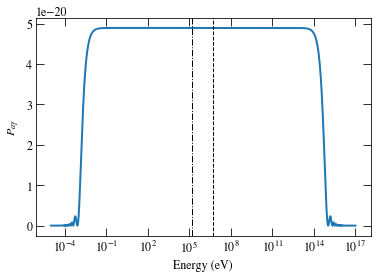

In [43]:
plt.semilogx(EGeV * u.GeV.to('eV'), (pa)[0], lw=2)

# the critical energy, onset of strong mixing regime
plt.axvline(EminGeV(m_neV=ml_iaxo.alp.m,
                    g11=ml_iaxo.alp.g,
                    BmuG=ml_iaxo.modules[0].B,
                    n_cm3=ml_iaxo.modules[0].nel) * u.GeV.to('eV'),
            lw=1., ls='--', color='k')

# maximum energy, end of strong mixing regime
plt.axvline(EmaxGeV(g11=ml_iaxo.alp.g, BmuG=ml_iaxo.modules[0].B) * u.GeV.to('eV'),
            lw=1., ls='-.', color='k')


plt.xlabel("Energy (eV)")
plt.ylabel("$P_{a\gamma}$")

print(pa[0].max())

In [44]:
print("{0:.2e}".format(f_integral * A.to("cm^2") * pa[0].max()))

1.24e-05 cm2


In [45]:
## Baby IAXO

In [46]:
B = 2. * u.T.to("1e-6 G")
L = 10 * u.m.to("kpc")
A = 0.77 * u.m**2.
print(B, L, A)

20000000000.0 3.2407792894443655e-19 0.77 m2


In [47]:
ml_baby_iaxo = ModuleList(alp, src, pin=pin, EGeV=EGeV, seed=0)

In [48]:
ml_baby_iaxo.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=B,  # B field strength
                   L0=L,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-100,  # electron density
                   r_abell=L * 1.1,  # full path, chosen that we only have a single cell
                   beta=0., 
                   eta=0.
                  )

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0


In [49]:
px, py, pa = ml_baby_iaxo.run()
print (pa.shape)

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>


(1, 2000)


3.321822432225612e-20


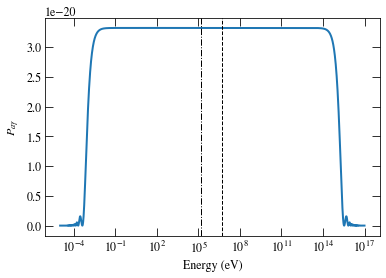

In [50]:
plt.semilogx(EGeV * u.GeV.to('eV'), (pa)[0], lw=2)

# the critical energy, onset of strong mixing regime
plt.axvline(EminGeV(m_neV=ml_iaxo.alp.m,
                    g11=ml_iaxo.alp.g,
                    BmuG=ml_iaxo.modules[0].B,
                    n_cm3=ml_iaxo.modules[0].nel) * u.GeV.to('eV'),
            lw=1., ls='--', color='k')

# maximum energy, end of strong mixing regime
plt.axvline(EmaxGeV(g11=ml_iaxo.alp.g, BmuG=ml_iaxo.modules[0].B) * u.GeV.to('eV'),
            lw=1., ls='-.', color='k')


plt.xlabel("Energy (eV)")
plt.ylabel("$P_{a\gamma}$")

print(pa[0].max())

In [51]:
print("{0:.2e}".format(f_integral * A.to("cm^2") * pa[0].max()))

2.87e-06 cm2


### Conversion from SN photons in galaxy

In [52]:
from alpsnlc.calc_alp_signal import ALPSNSignal

In [53]:
snalp = ALPSNSignal(Mprog=18.)

In [54]:
EMeV = np.logspace(-3, 3, 100)
EGeV = EMeV * u.MeV.to("GeV")
t = np.linspace(0.,20.,101)
ee, tt = np.meshgrid(EMeV, t, indexing='ij')

In [55]:
# ALP flux in 10^52/MeV/s
dnde = snalp(g10=0.2, EMeV=EMeV, ts=t)
dnde.shape

(100, 101)

In [56]:
# integrate over energy and average over time
# to get average rate
n_avg = simps(simps(dnde * ee, np.log(ee), axis=0), t) / (t.max() - t.min()) * 1e52

In [57]:
# divide by luminosity distance
dL = 10. * u.kpc

In [58]:
print("{0:e} s".format(n_avg / (4. * np.pi * dL.to('cm') ** 2.)))

8.912008e+04 1 / cm2 s


conversion in GMF

In [59]:
pa_in = np.diag([0., 0., 1.])
px_in = np.diag([1., 0., 0.])
py_in = np.diag([0., 1., 0.])

In [60]:
src = Source(z=0.0, l=0., b=0.)  # galactic center


ml = ModuleList(ALP(m=0.01, g=2.),
                src, 
                pin=pa_in,
                EGeV=EGeV, seed=0)

# add the GMF propagation module
ml.add_propagation("GMF", 0, model='jansson12', galactic=10.)

environs.py:1039 --- INFO: Using inputted chi


In [61]:
px, py, pa = ml.run()

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>


In [62]:
prx = ml.modules["GMF"].show_conv_prob_vs_r(pa_in, px_in)
pry = ml.modules["GMF"].show_conv_prob_vs_r(pa_in, py_in)
pra = ml.modules["GMF"].show_conv_prob_vs_r(pa_in, pa_in)

0.09650757322312344


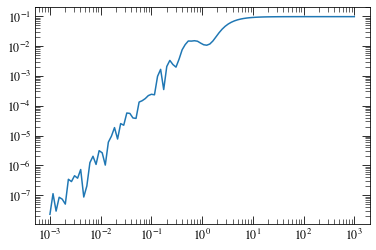

In [63]:
plt.loglog(EMeV, (px + py)[0])
print ((px + py).max())

1.3195165872804324


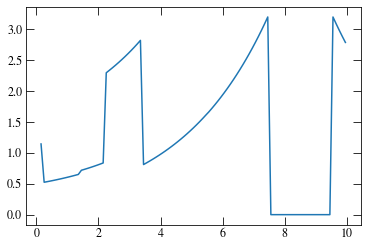

In [64]:
plt.plot(ml.modules["GMF"].r, ml.modules["GMF"].B)

# average B transversal along line of sight
B_avg = simps(ml.modules["GMF"].B, ml.modules["GMF"].r[::-1]) / \
    (ml.modules["GMF"].r.max() - ml.modules["GMF"].r.min())
print(B_avg)

In [65]:
A = 0.5 * u.m**2

In [66]:
"{0:e} / s".format(n_avg / (4. * np.pi * dL.to('cm') ** 2.) * (px + py).max() * A.to("cm^2"))

'4.300381e+07 / s'

In [67]:
"{0:e} / s".format(n_avg / (4. * np.pi * dL.to('cm') ** 2.))

'8.912008e+04 1 / cm2 / s'